In [1]:
import IPython.display as ipd
import torch
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import torch.nn.functional as F
import librosa.output
from matplotlib import cm
import matplotlib

In [2]:
matplotlib.style.use('ggplot')

In [3]:
from data import SpatialAudioDatasetWaveform
from network import center_trim, Demucs

In [536]:
test_dir = '/projects/grail/audiovisual/datasets/DinTaiFung/1_voice_1_bg_hard/test'
data_test = SpatialAudioDatasetWaveform(test_dir, n_sources=1, n_backgrounds=1)
device = torch.device('cuda:0')

In [537]:
!ls /projects/grail/audiovisual/datasets/DinTaiFung/

1_voice_1_bg_hard		  mics_8_radius_3_voice_1_bg_1_all_noatten
mics_8_radius_3			  simple_1_voice_1_bg
mics_8_radius_3_voice_1_bg_1	  simple_1_voice_1_bg_hard
mics_8_radius_3_voice_1_bg_1_all  simple_1_voice_1_bg_harder


In [538]:
kwargs = {
    'num_workers': 4,
    'pin_memory': True
}

In [539]:
test_loader = torch.utils.data.DataLoader(data_test,
                                          batch_size=1,
                                          **kwargs)

In [544]:
%ls checkpoints/1_voice_1_bg_hard*

checkpoints/1_voice_1_bg_hard_0.pt   checkpoints/1_voice_1_bg_hard_32.pt
checkpoints/1_voice_1_bg_hard_10.pt  checkpoints/1_voice_1_bg_hard_33.pt
checkpoints/1_voice_1_bg_hard_11.pt  checkpoints/1_voice_1_bg_hard_34.pt
checkpoints/1_voice_1_bg_hard_12.pt  checkpoints/1_voice_1_bg_hard_35.pt
checkpoints/1_voice_1_bg_hard_13.pt  checkpoints/1_voice_1_bg_hard_36.pt
checkpoints/1_voice_1_bg_hard_14.pt  checkpoints/1_voice_1_bg_hard_37.pt
checkpoints/1_voice_1_bg_hard_15.pt  checkpoints/1_voice_1_bg_hard_38.pt
checkpoints/1_voice_1_bg_hard_16.pt  checkpoints/1_voice_1_bg_hard_39.pt
checkpoints/1_voice_1_bg_hard_17.pt  checkpoints/1_voice_1_bg_hard_3.pt
checkpoints/1_voice_1_bg_hard_18.pt  checkpoints/1_voice_1_bg_hard_40.pt
checkpoints/1_voice_1_bg_hard_19.pt  checkpoints/1_voice_1_bg_hard_41.pt
checkpoints/1_voice_1_bg_hard_1.pt   checkpoints/1_voice_1_bg_hard_42.pt
checkpoints/1_voice_1_bg_hard_20.pt  checkpoints/1_voice_1_bg_hard_43.pt
checkpoints/1_voice_1_bg_hard_21.pt  checkpoints/1_v

In [182]:
model = Demucs(sources=2, n_audio_channels=6)

In [629]:
# model.load_state_dict(torch.load('checkpoints/mics8_radius3_demucs_nospatial_47.pt'))
# model.load_state_dict(torch.load('checkpoints/mics8_radius3_demucs_nospatial_10.pt').module.state_dict())
model.load_state_dict(torch.load('checkpoints/1_voice_1_bg_hard_49.pt'))
model.to(device)

Demucs(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(6, 64, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (4): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (5): Sequential(
      (0): Conv1d(1024

In [630]:
with torch.no_grad():
    for batch_idx, (data, label_voice_signals, label_bg_signals, label_voice_locs, label_bg_locs) in enumerate(test_loader):
        print(batch_idx)
        if batch_idx != 8: continue
#         data = label_bg_signals[:,0,:,:]
        data = data.to(device)
        label_voice_signals = label_voice_signals.to(device)
        label_bg_signals = label_bg_signals.to(device)
        label_voice_locs = label_voice_locs.to(device)
        label_bg_locs = label_bg_locs.to(device)
        
        # Normalize input
        data_transformed = (data * 2**15).round() / 2**15
        ref = data_transformed.mean(0)
        data_transformed = (data_transformed - ref.mean()) / ref.std()

        # Run through the model
        valid_length = model.valid_length(data_transformed.shape[-1])
        delta = valid_length - data_transformed.shape[-1]
        padded = F.pad(data_transformed, (delta // 2, delta - delta // 2))

        output_signal, output_locs = model(padded)
        output_signal = center_trim(output_signal, data_transformed)
        output_locs = center_trim(output_locs, data_transformed)
        
        output_signal = output_signal * ref.std() + ref.mean()
        output_voices = output_signal[:, :label_voice_signals.shape[1]]
        output_voice_locs = output_locs[:, :label_voice_locs.shape[1]]
        output_backgrounds = output_signal[:, label_voice_signals.shape[1] : label_voice_signals.shape[1] + label_bg_signals.shape[1]]
        output_background_locs = output_locs[:, label_voice_locs.shape[1] : label_voice_locs.shape[1] + label_bg_locs.shape[1]]
        
        break

0
1
2
3
4
5
6
7
8


In [631]:
data.shape

torch.Size([1, 6, 66150])

In [632]:
model.loss(data,
          output_voices, label_voice_signals,
          output_backgrounds, label_bg_signals,
          output_voice_locs, label_voice_locs,
          output_background_locs, label_bg_locs)

(tensor(7.1713, device='cuda:0'),
 {'reconstruction_voices_loss': tensor(0.0060, device='cuda:0'),
  'reconstruction_bg_loss': tensor(0.0121, device='cuda:0'),
  'reconstruction_combined_loss': tensor(0.0101, device='cuda:0')})

In [633]:
label_voice_signals.shape

torch.Size([1, 1, 6, 66150])

In [634]:
label_bg_signals.shape

torch.Size([1, 1, 6, 66150])

In [635]:
data.shape

torch.Size([1, 6, 66150])

In [636]:
!nvidia-smi

Fri Feb 21 20:00:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 440.44       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:04:00.0 Off |                  N/A |
| 38%   59C    P2    80W / 250W |   8237MiB / 12196MiB |     72%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 43%   59C    P2    74W / 250W |   9799MiB / 12196MiB |     72%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [637]:
inputs = data[0,:,:].cpu().detach().numpy()

In [638]:
v_min = 1.5*np.min(inputs)
v_max = 1.5*np.max(inputs)

[]

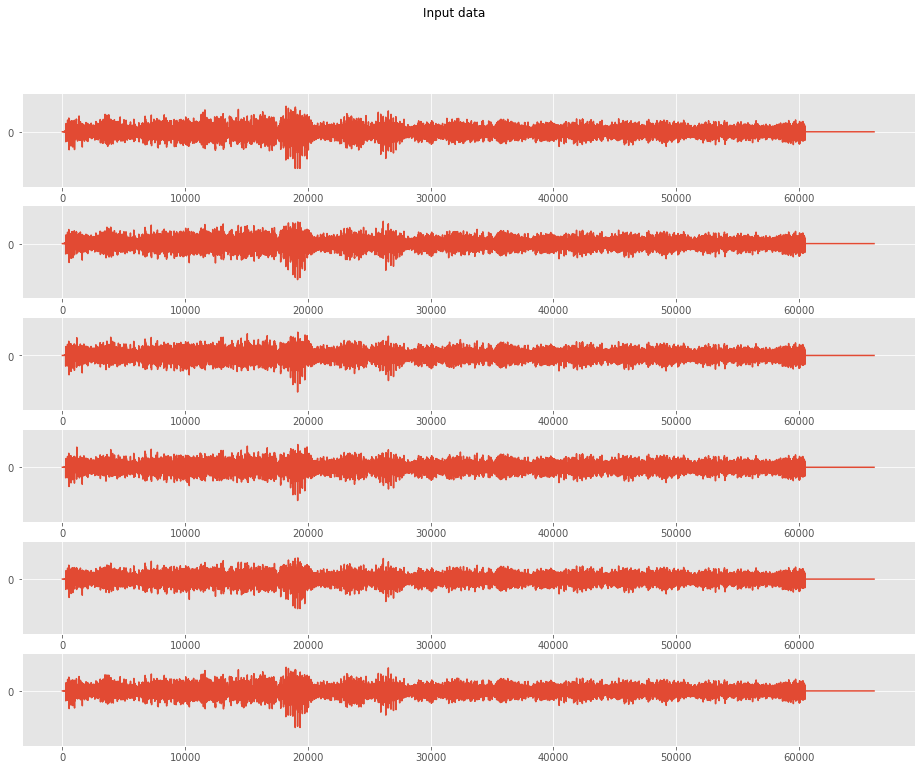

In [639]:
plt.figure(figsize=(16, 12))
for i in range(inputs.shape[0]):
    plt.subplot(inputs.shape[0], 1, i+1)
    plt.plot(inputs[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Input data")    
plt.plot()

In [640]:
label_voices = label_voice_signals[0,0,:,:].cpu().detach().numpy()
label_bg = label_bg_signals[0,0,:,:].cpu().detach().numpy()

[]

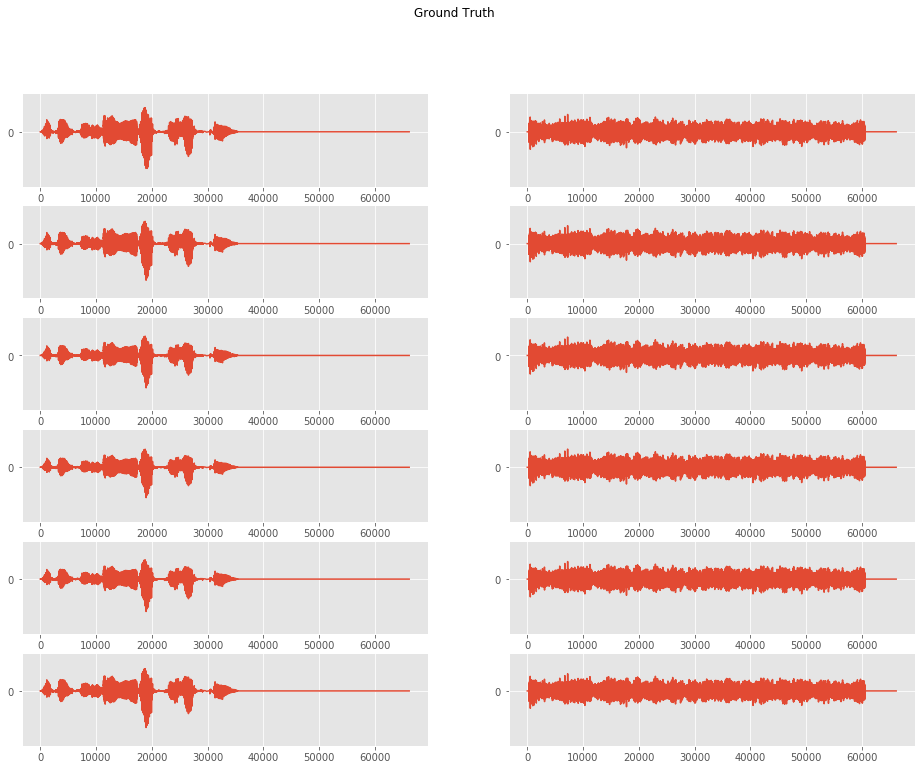

In [641]:
plt.figure(figsize=(16, 12))
for i in range(label_voices.shape[0]):
    plt.subplot(label_voices.shape[0], 2, 2*i+1)
    plt.plot(label_voices[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
    plt.subplot(label_voices.shape[0], 2, 2*i+2)
    plt.plot(label_bg[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Ground Truth")    
plt.plot()

In [642]:
np.max(label_bg)

0.50271606

In [643]:
np.max(label_voices)

0.6607361

In [644]:
output_voice_signals = output_voices[0,0,:,:].cpu().detach().numpy()
output_bg_signals = output_backgrounds[0,0,:,:].cpu().detach().numpy()

[]

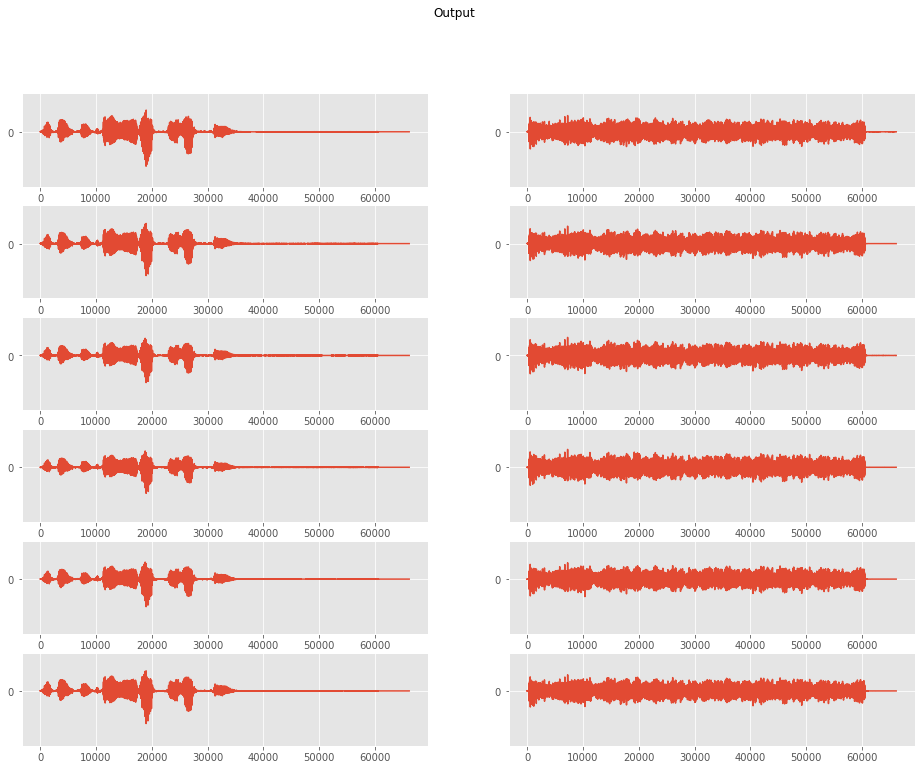

In [645]:
plt.figure(figsize=(16, 12))
for i in range(output_voice_signals.shape[0]):
    plt.subplot(output_voice_signals.shape[0], 2, 2*i+1)
    plt.plot(output_voice_signals[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
    plt.subplot(output_voice_signals.shape[0], 2, 2*i+2)
    plt.plot(output_bg_signals[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Output")
plt.plot()

In [646]:
ipd.Audio(data=(inputs[0]), rate=22050)

In [647]:
ipd.Audio(data=(label_voices[0]), rate=22050, normalize=False)

In [648]:
ipd.Audio(data=(label_bg[0]), rate=22050, normalize=False)

In [649]:
np.min(output_voice_signals[0])

-0.94038194

In [650]:
np.min(label_voices[0])

-1.0

In [651]:
ipd.Audio(data=(output_voice_signals[0]), rate=22050, normalize=True)

In [652]:
ipd.Audio(data=(output_bg_signals[0]), rate=22050, normalize=True)

In [605]:
from librosa.core import stft, istft
from librosa.display import specshow

In [35]:
y = output_voice_signals[0]

[]

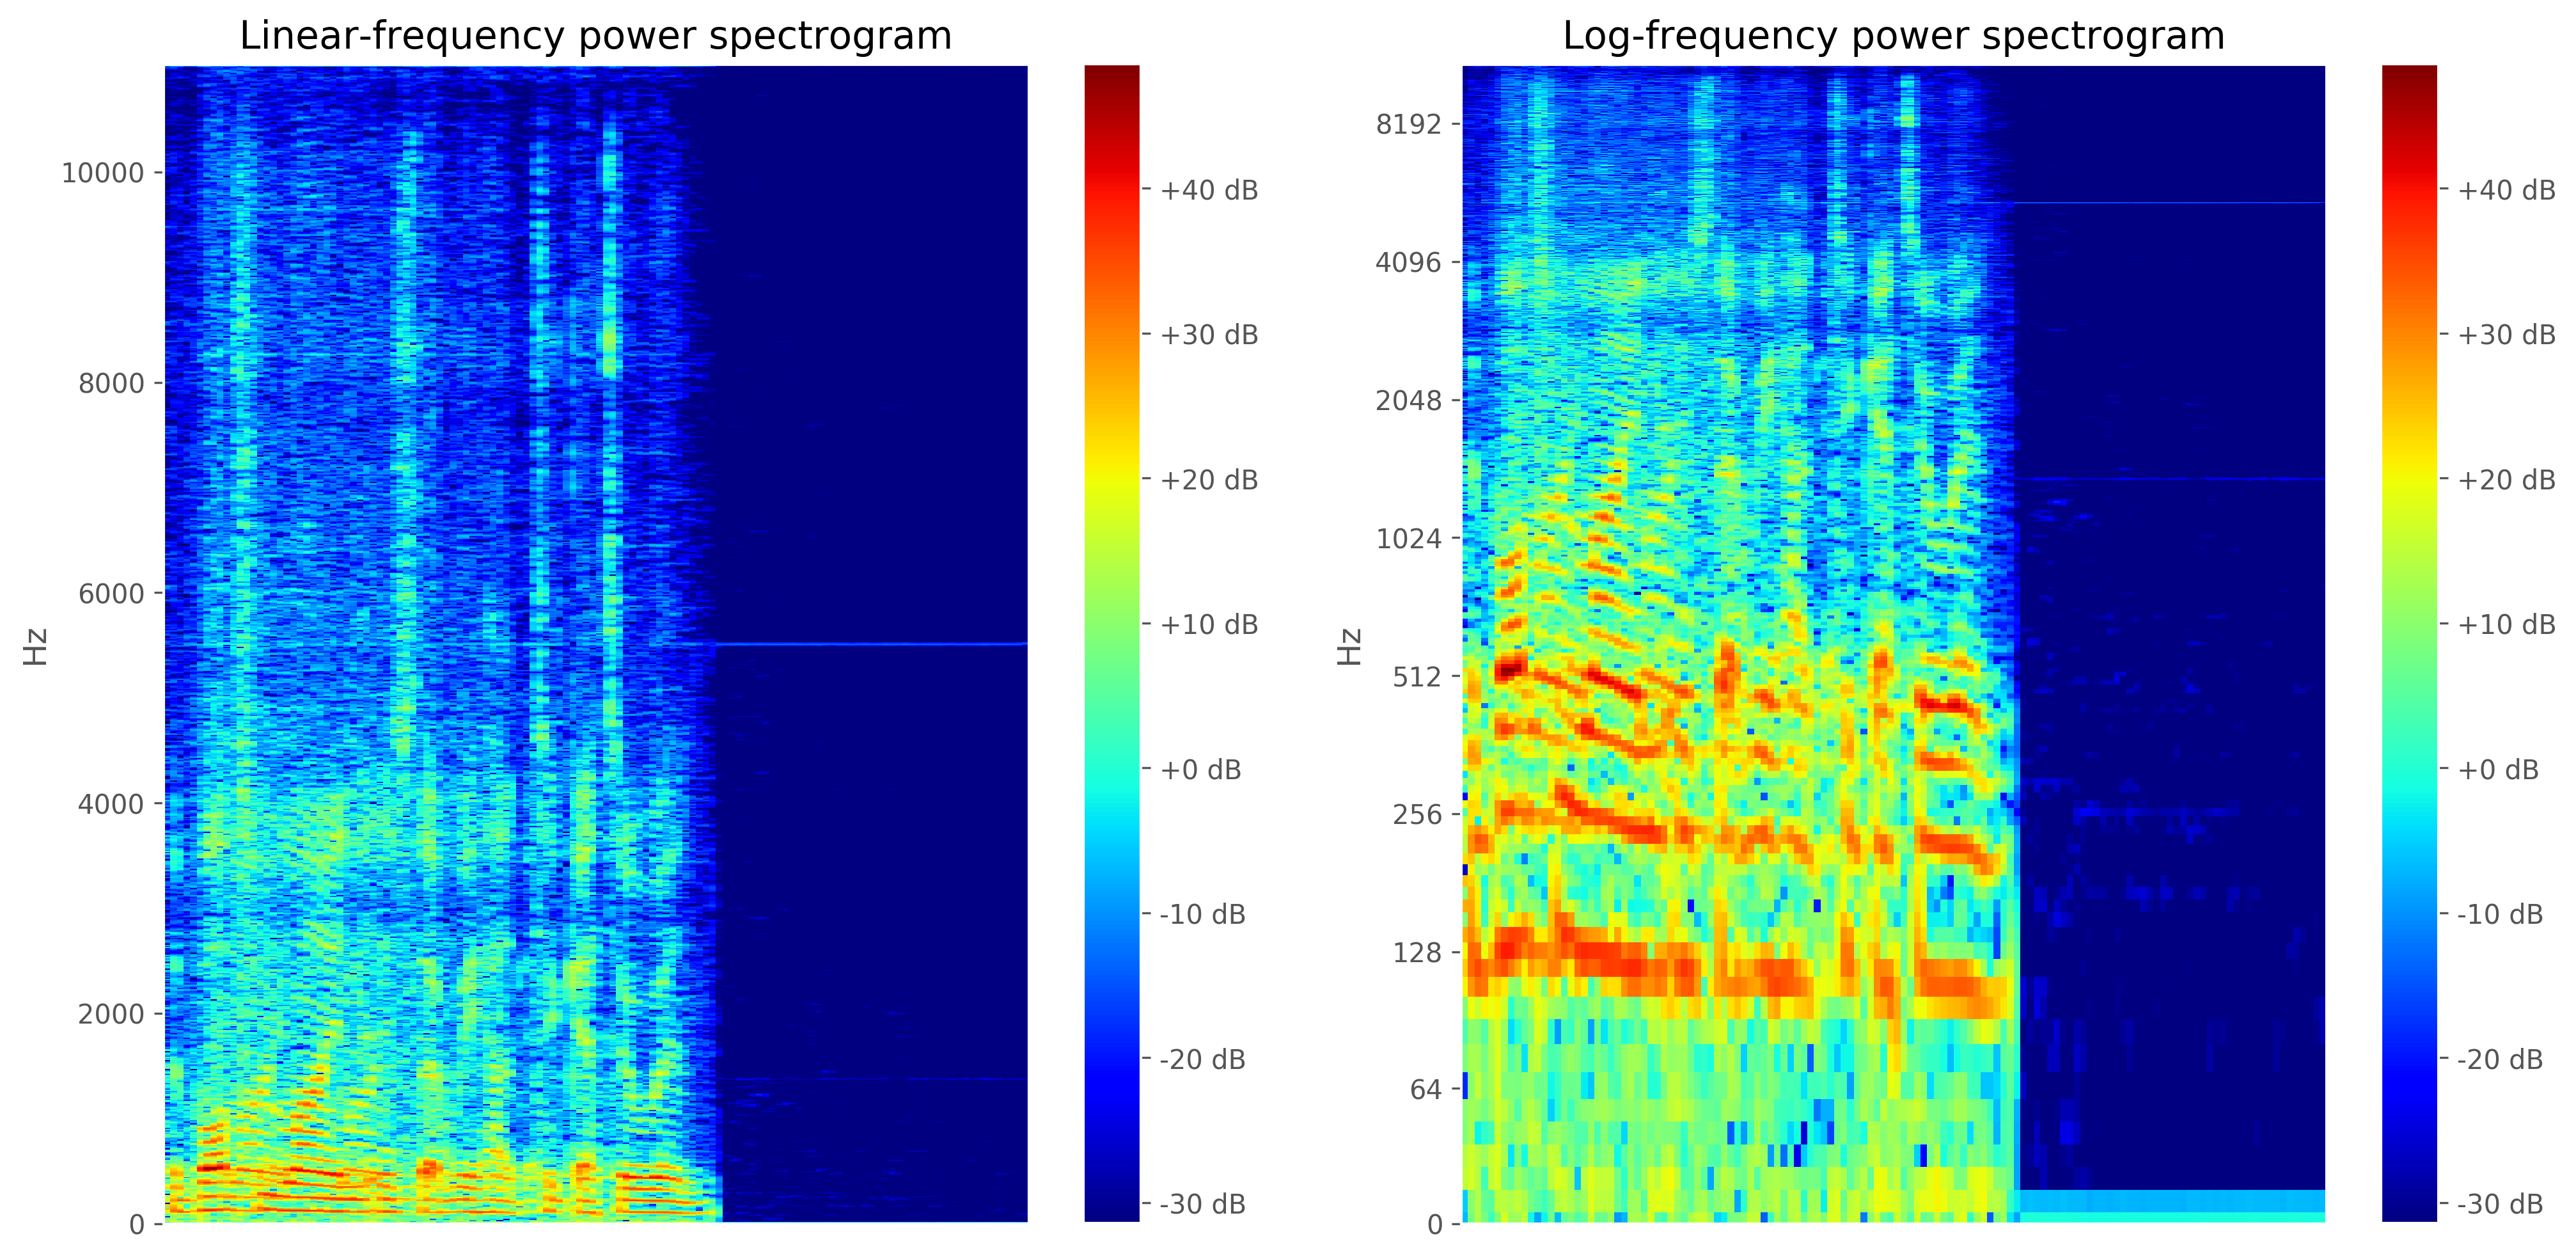

In [36]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [37]:
# D = np.clip(D, -20, 0)

[]

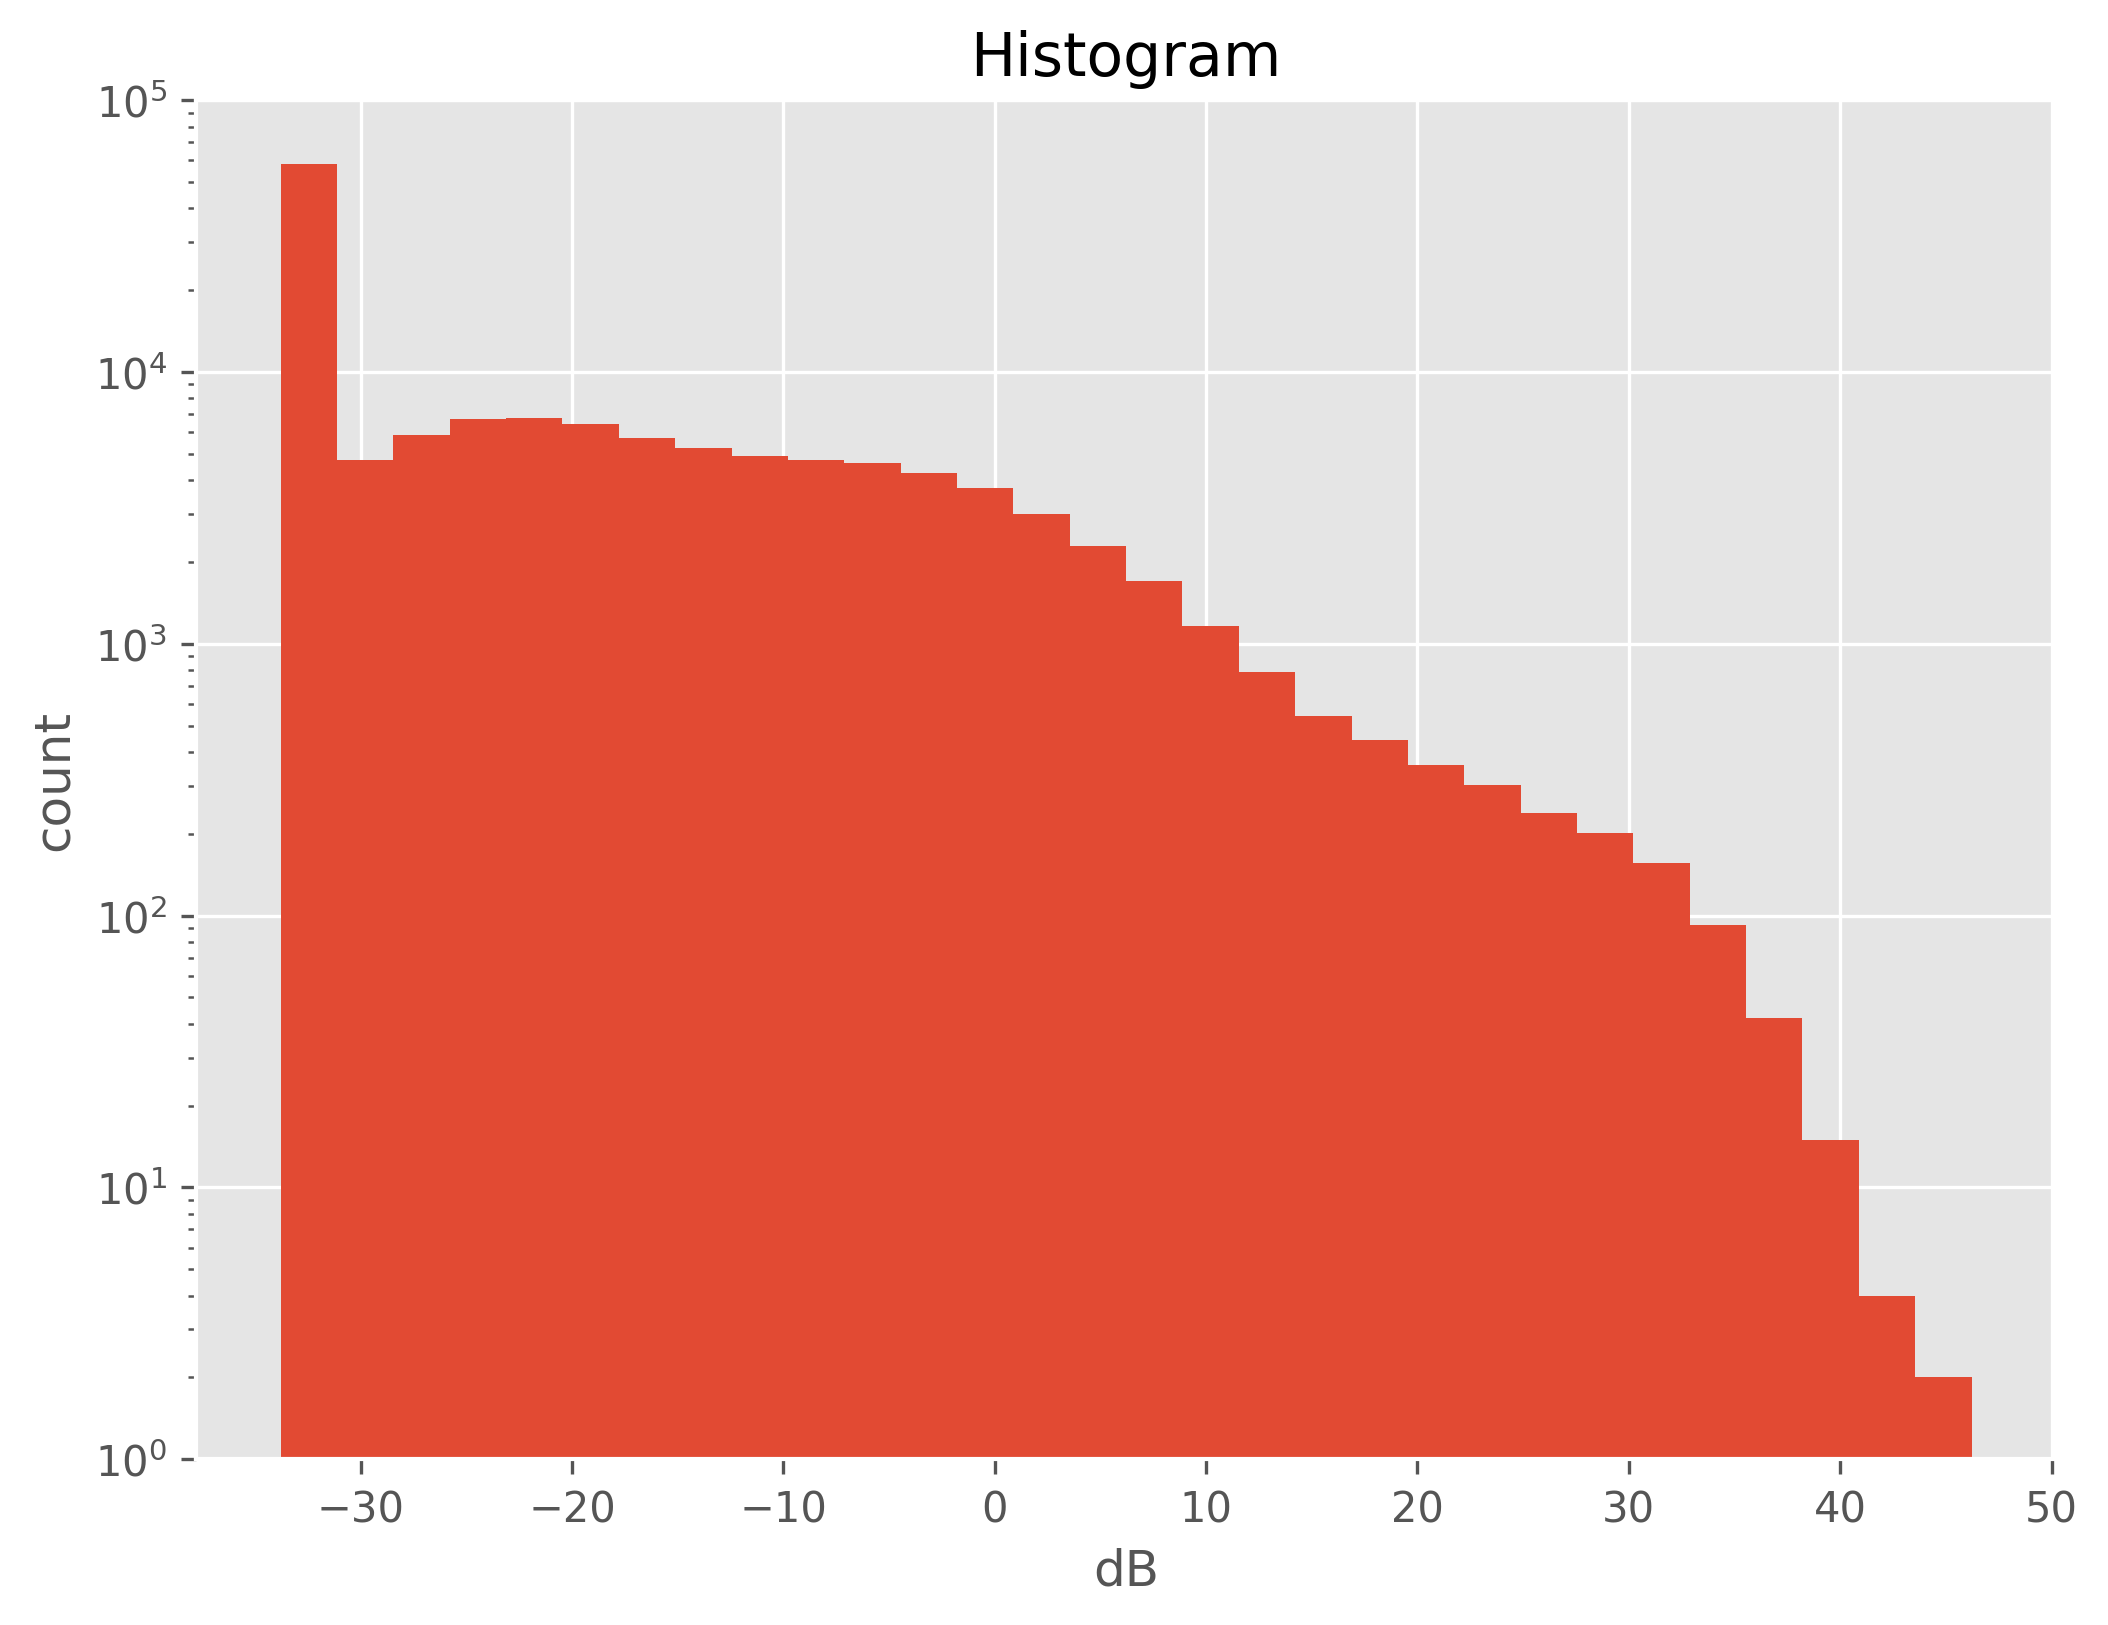

In [41]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

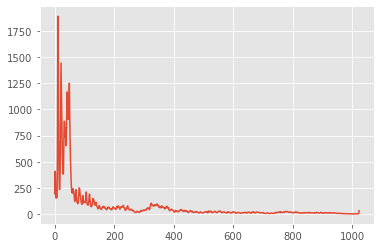

In [42]:
Y = stft(y)
plt.plot(np.sum(np.abs(Y), axis=1))

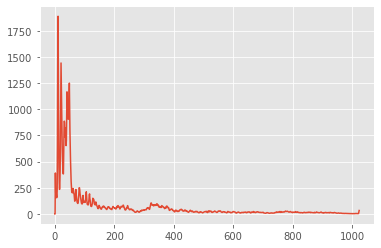

In [43]:
Y[:2, :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
Y[np.where(np.sum(np.abs(Y), axis=1) >= 10), :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
# Y = librosa.util.normalize(Y)

In [ ]:
plt.plot(istft(Y))

In [ ]:
D = librosa.amplitude_to_db(np.abs(Y), ref=1.0)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

In [ ]:
newy = istft(Y)

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(newy)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
y_gt = label_voices[0]
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_gt)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
x = data[0][1].cpu().numpy()

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
ipd.Audio(data=(labels[3]), rate=22050)

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
top = np.sum(librosa.util.normalize(outputs[0]) ** 2) / outputs[0].shape[0]
bottom = np.sum(librosa.util.normalize(labels[0]) ** 2) / labels[0].shape[0]

In [ ]:
SDR = 10 * np.log10(top / bottom)

In [ ]:
print(SDR)

In [ ]:
binaural = False
if outputs.shape[0] == 2:
    binaural = True

In [ ]:
import os
base_dir = 'jan24'
os.makedirs(base_dir, exist_ok=True)

In [ ]:
if not binaural:
    for i in range(outputs.shape[0]):
        librosa.output.write_wav('{}/input_{}.wav'.format(base_dir, i), inputs[i], sr=22050)
        librosa.output.write_wav('{}/output_{}.wav'.format(base_dir, i), 100 * outputs[i], sr=22050)
        librosa.output.write_wav('{}/label_{}.wav'.format(base_dir, i), labels[i], sr=22050)
else:
    librosa.output.write_wav('{}/input.wav'.format(base_dir, i), np.asfortranarray(np.vstack(inputs)), sr=22050)
    librosa.output.write_wav('{}/output.wav'.format(base_dir, i), np.asfortranarray(np.vstack(outputs)), sr=22050)
    librosa.output.write_wav('{}/label.wav'.format(base_dir, i), np.asfortranarray(np.vstack(labels)), sr=22050)
        

233 => 1.121
150 => 1.835
100 => 1.036
50 => 0.648